In [58]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import chi2, expon

In [59]:
file_path = "Raw Data\GG1 Data Collection.xlsx"

sheets = pd.read_excel(file_path, sheet_name=None, header=None)

extracted_data = {}

for sheet_name, sheet_data in sheets.items():
    if (sheet_name not in ['Template', 'Overall Stats', 'Edits to make']) and (3 in sheet_data.columns):
        column_d_values = sheet_data.loc[5:, 3].dropna()
        extracted_data[sheet_name] = column_d_values.reset_index(drop=True) 


df = pd.concat(extracted_data, names=["Sheet", "Index"]).reset_index(level=0)
df.columns = ["Date", "Time Taken"]
df


,Date,Time Taken
Index,,
0,Day 1,00:00:29.650000
1,Day 1,00:02:07.800000
2,Day 1,00:02:08.920000
3,Day 1,00:01:21.100000
4,Day 1,00:00:38.590000
...,...,...
34,Day 11,00:00:24.200000
35,Day 11,00:01:04.410000
36,Day 11,00:00:51.650000


In [60]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

df["time_sec"] = df["Time Taken"].apply(time_to_seconds)
df

,Date,Time Taken,time_sec
Index,,,
0,Day 1,00:00:29.650000,29
1,Day 1,00:02:07.800000,127
2,Day 1,00:02:08.920000,128
3,Day 1,00:01:21.100000,81
4,Day 1,00:00:38.590000,38
...,...,...,...
34,Day 11,00:00:24.200000,24
35,Day 11,00:01:04.410000,64
36,Day 11,00:00:51.650000,51


Average: 96.73774509803921


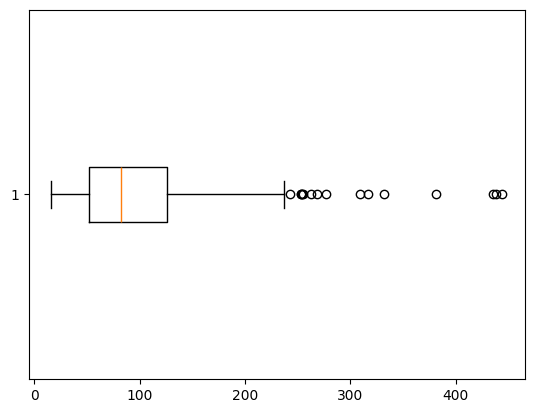

In [61]:
print("Average: " + str(df["time_sec"].mean()))
plt.boxplot(df["time_sec"], vert=False)
plt.show()

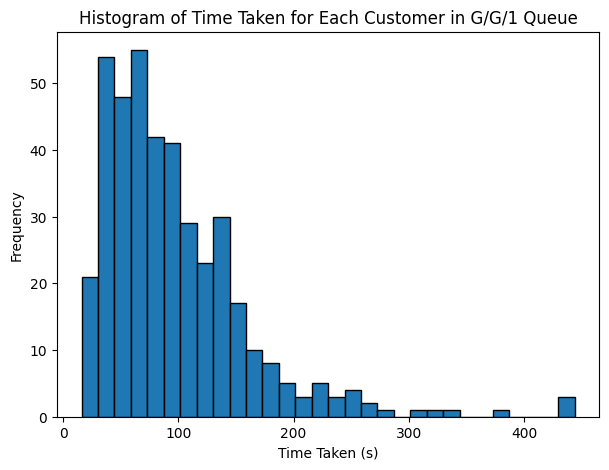

In [62]:
plt.figure(figsize=(7,5))
freq, bin_edges, _ = plt.hist(df["time_sec"], bins=30, edgecolor="black")
plt.xlabel("Time Taken (s)")
plt.ylabel("Frequency")
plt.title("Histogram of Time Taken for Each Customer in G/G/1 Queue")
plt.show()

In [63]:
len(df["time_sec"]), min(df["time_sec"]), max(df["time_sec"])

(408, 16, 444)

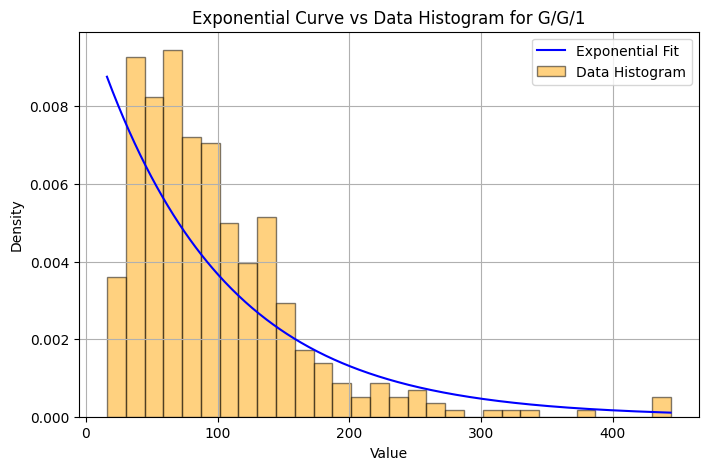

In [64]:
# Simulate exponential curve
data_min = min(df["time_sec"])
data_max = max(df["time_sec"])
lambda_est = 1 / np.mean(df["time_sec"]) 

x = np.linspace(data_min, data_max, len(df["time_sec"]))
y = lambda_est * np.exp(-lambda_est * x)
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Exponential Fit", color="blue")
plt.hist(df["time_sec"], bins=30, density=True, alpha=0.5, label="Data Histogram", color="orange", edgecolor="black")

plt.title("Exponential Curve vs Data Histogram for G/G/1")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

Average: 88.4147582697201


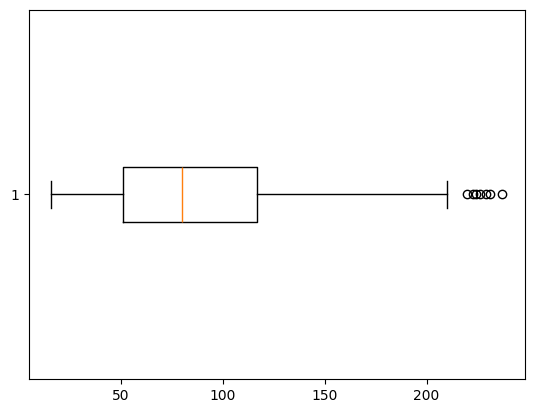

In [65]:
# REMOVING OUTLIERS
Q1 = df["time_sec"].quantile(0.25)
Q3 = df["time_sec"].quantile(0.75)
IQR = Q3 - Q1

# Range for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["time_sec"] >= lower_bound) & (df["time_sec"] <= upper_bound)]


print("Average: " + str(df["time_sec"].mean()))
plt.boxplot(df["time_sec"], vert=False)
plt.show()

In [66]:
# Exponential Test
def calc_chi_squared(freq, expected):
    chi2val = sum((o-e)**2 / e for o, e in zip(freq, expected))
    # chi2val = sum((o-e)**2 / e for o, e in zip(observed_combined, expected_combined))
    dfree = len(bin_edges) - 2


    alpha = 0.05
    critical_value = chi2.ppf(1-alpha, dfree)
    pval = 1 - chi2.cdf(chi2val, dfree)
    reject_statement = (f"Fail to reject H0: Data fits the exponential distribution at {alpha*100}% significance." if chi2val< critical_value else f"Reject H0: Data does not fit the exponential distribution at {alpha*100}% significance.")
    return f"""Lambda & Lambda_est: {1/lambda_est} | {lambda_est})
Chi-Square Statistic: {chi2val}
Critical Value (5% confidence): {critical_value}
df: {dfree}
p-value: {pval}
{reject_statement}
-------------------------------------"""
    # if chi2val < critical_value:
    #     print("Fail to reject H0: Data fits the exponential distribution.")
    # else:
    #     print("Reject H0: Data does not fit the exponential distribution.")


lambda_est = 1/np.mean(df['time_sec'])
expected = []
for i in range(len(bin_edges)-1):
    p = expon.cdf(bin_edges[i+1], scale=1/lambda_est) - expon.cdf(bin_edges[i], scale=1/lambda_est)
    expected.append(p * len(df["time_sec"]))



# Combine small expected bins to ensure all expected values >= 5
observed_combined = []
expected_combined = []
new_bin_edges = [bin_edges[0]]  # Start the new bin edges with the first edge
threshold = 5

# Initialize temporary bins for combining
temp_observed = 0
temp_expected = 0

for o, e, left_edge, right_edge in zip(freq, expected, bin_edges[:-1], bin_edges[1:]):
    temp_observed += o
    temp_expected += e

    if temp_observed >= threshold:  # If combined bin meets the threshold
        observed_combined.append(temp_observed)
        expected_combined.append(temp_expected)
        new_bin_edges.append(right_edge)  # Add the current bin's right edge
        temp_observed = 0  # Reset temporary bins
        temp_expected = 0

# If any leftover bin exists, add it to the last combined bin
if temp_observed > 0:
    if observed_combined:
        observed_combined[-1] += temp_observed
        expected_combined[-1] += temp_expected
        new_bin_edges[-1] = bin_edges[-1]  # Update the last right edge
    else:
        # Handle the case where no bins met the threshold
        observed_combined.append(temp_observed)
        expected_combined.append(temp_expected)
        new_bin_edges.append(bin_edges[-1])


print(calc_chi_squared(freq, expected))
print("With combined:")
print(calc_chi_squared(observed_combined, expected_combined))

Lambda & Lambda_est: 88.4147582697201 | 0.011310328949261808)
Chi-Square Statistic: 129.81328198323865
Critical Value (5% confidence): 42.55696780429269
df: 29
p-value: 1.0325074129013956e-14
Reject H0: Data does not fit the exponential distribution at 5.0% significance.
-------------------------------------
With combined:
Lambda & Lambda_est: 88.4147582697201 | 0.011310328949261808)
Chi-Square Statistic: 110.20026161129837
Critical Value (5% confidence): 42.55696780429269
df: 29
p-value: 2.14430695422152e-11
Reject H0: Data does not fit the exponential distribution at 5.0% significance.
-------------------------------------


In [67]:
print(min(df['time_sec']), max(df['time_sec']))
print(f"Expected Frequencies (combined): {expected_combined}")
print(f"Observed Frequencies (combined): {observed_combined}")
print(f"New Bin Edges: {new_bin_edges}")

16 237
Expected Frequencies (combined): [48.86862439919048, 41.58646982247725, 35.38946499022916, 30.115906390730295, 25.628186749521113, 21.809204330323347, 18.559307303731984, 15.79369345058781, 13.440197348366723, 11.43740729983082, 9.733062867422777, 8.282691198957915, 7.048446561144941, 11.102435758976053, 8.04011298515412, 11.688578822299444, 6.829749945245089]
Observed Frequencies (combined): [21.0, 54.0, 48.0, 55.0, 42.0, 41.0, 29.0, 23.0, 30.0, 17.0, 10.0, 8.0, 5.0, 8.0, 7.0, 5.0, 5.0]
New Bin Edges: [16.0, 30.266666666666666, 44.53333333333333, 58.800000000000004, 73.06666666666666, 87.33333333333334, 101.60000000000001, 115.86666666666667, 130.13333333333333, 144.4, 158.66666666666669, 172.93333333333334, 187.20000000000002, 201.46666666666667, 230.0, 258.53333333333336, 329.8666666666667, 444.0]


In [68]:
df_chi2_expected = pd.DataFrame({
    "Bin Range": new_bin_edges[:-1],
    "Observed Frequency": observed_combined,
    "Expected Frequency": expected_combined
})
df_chi2_expected["Probability"] = df_chi2_expected["Expected Frequency"] / sum(expected_combined)
df_chi2_expected["Cumulative Probability"] = df_chi2_expected["Probability"].cumsum()
df_chi2_expected["Chi-Square Contribution"] = (df_chi2_expected["Expected Frequency"]-df_chi2_expected["Observed Frequency"])**2 / df_chi2_expected["Expected Frequency"]
df_chi2_expected.to_excel("Raw Data/df_chi2_stats.xlsx", index=False)
df_chi2_expected

,Bin Range,Observed Frequency,Expected Frequency,Probability,Cumulative Probability,Chi-Square Contribution
0,16.000000,21.0,48.868624,0.150202,0.150202,15.892819
1,30.266667,54.0,41.586470,0.127819,0.278021,3.705429
2,44.533333,48.0,35.389465,0.108772,0.386793,4.493586
3,58.800000,55.0,30.115906,0.092564,0.479357,20.561165
4,73.066667,42.0,25.628187,0.078770,0.558127,10.458651
5,87.333333,41.0,21.809204,0.067032,0.625160,16.886753
6,101.600000,29.0,18.559307,0.057044,0.682203,5.873499
7,115.866667,23.0,15.793693,0.048543,0.730746,3.288075
8,130.133333,30.0,13.440197,0.041310,0.772056,20.403500
9,144.400000,17.0,11.437407,0.035154,0.807209,2.705372


In [69]:
print(sum(df_chi2_expected["Chi-Square Contribution"]))

110.20026161129837


In [70]:
df_chi2_original = pd.DataFrame({
    "Bin Range": bin_edges[:-1],
    "Observed Frequency": freq,
    "Expected Frequency": expected
})

df_chi2_original

,Bin Range,Observed Frequency,Expected Frequency
0,16.000000,21.0,48.868624
1,30.266667,54.0,41.586470
2,44.533333,48.0,35.389465
3,58.800000,55.0,30.115906
4,73.066667,42.0,25.628187
5,87.333333,41.0,21.809204
6,101.600000,29.0,18.559307
7,115.866667,23.0,15.793693
8,130.133333,30.0,13.440197
9,144.400000,17.0,11.437407


In [71]:
# Calculating measures of performance
df_summary = pd.read_excel(file_path, sheet_name="Overall Stats", usecols="G:H")
df_summary = df_summary[7:10]
df_summary.columns = ["Variable", "Value"]
df_summary

,Variable,Value
7,Avg No. of Arrivals,40.545455
8,Avg No. of Departures,37.090909
9,Avg Time Taken per Customer,00:01:37.258000


In [72]:
def time_to_seconds(time):
    return (time.hour*3600 + time.minute*60 + time.second)


summary_data = {}

for sheet_name, sheet_data in sheets.items():
    if (sheet_name not in ['Template', 'Overall Stats', 'Edits to make']) and (3 in sheet_data.columns):
        column_d_values = sheet_data.loc[4:12, 6:7].dropna()
        summary_data[sheet_name] = column_d_values.reset_index(drop=True) 

df_summary_detailed = pd.concat(summary_data, names=["Date", "Index"]).reset_index(level=0)
df_summary_detailed.columns = ["Date", "Variable", "Value"]
df_summary_detailed = df_summary_detailed.pivot(index="Date", columns="Variable", values="Value")
df_summary_detailed["Service Time (in seconds)"] = df_summary_detailed["Avg. Service Time (per customer)"].apply(time_to_seconds)
df_summary_detailed


Variable,Avg. Service Time (per customer),No. of Arrivals,No. of Arrivals (Total),No. of Counters Open,No. of Departures,No. of Departures (Total),No. of People Left in Queue (after 1h period),Service Time (in seconds)
Date,,,,,,,,
Day 1,00:02:02.514000,32,128,4,27,108,5,122
Day 10,00:02:02.716000,34,170,5,30,150,4,122
Day 11,00:01:34.894000,40,160,4,39,156,1,94
Day 2,00:01:14.585000,51,204,4,48,192,3,74
Day 3,00:01:37.730000,41,164,4,37,148,4,97
Day 4,00:02:03.577000,33,132,4,30,120,3,123
Day 5,00:01:39.631000,40,160,4,36,144,4,99
Day 6,00:01:43.007000,39,156,4,35,140,4,103
Day 7,00:01:25.417000,46,184,4,43,172,3,85


In [73]:
df

,Date,Time Taken,time_sec
Index,,,
0,Day 1,00:00:29.650000,29
1,Day 1,00:02:07.800000,127
2,Day 1,00:02:08.920000,128
3,Day 1,00:01:21.100000,81
4,Day 1,00:00:38.590000,38
...,...,...,...
34,Day 11,00:00:24.200000,24
35,Day 11,00:01:04.410000,64
36,Day 11,00:00:51.650000,51


In [74]:
df.dtypes

Date          object
Time Taken    object
time_sec       int64
dtype: object

In [75]:
df_filtered = df.reset_index().groupby("Date")["time_sec"].mean()
df_filtered = pd.DataFrame(df_filtered).rename(columns={"time_sec": "avg_time_sec"})
df_filtered

,avg_time_sec
Date,
Day 1,107.920000
Day 10,103.678571
Day 11,90.105263
Day 2,74.041667
Day 3,84.257143
Day 4,95.423077
Day 5,88.441176
Day 6,102.600000
Day 7,84.930233


In [76]:
df_hour = pd.DataFrame(df_filtered["avg_time_sec"])
df_hour["Avg Customers Per Hour"] = 3600 / df_filtered["avg_time_sec"]

weighted_avg = 3600 / (df_hour["Avg Customers Per Hour"].mean())
print(f"Weighted Avg(sec): {weighted_avg}\nAvg Customers Per Hour: {df_hour['Avg Customers Per Hour'].mean()}")

df_hour

Weighted Avg(sec): 89.00485710075814
Avg Customers Per Hour: 40.44723082836493


,avg_time_sec,Avg Customers Per Hour
Date,,
Day 1,107.920000,33.358043
Day 10,103.678571,34.722701
Day 11,90.105263,39.953271
Day 2,74.041667,48.621272
Day 3,84.257143,42.726348
Day 4,95.423077,37.726723
Day 5,88.441176,40.705022
Day 6,102.600000,35.087719
Day 7,84.930233,42.387733


### Calculating M/M/1 and Kingman's formula

In [77]:
def calculate_mm1_performance(lambda_, mu):

       rho = lambda_/mu

       L_s = rho / (1-rho)
       W_s = 1 / (mu-lambda_)
       W_q = rho / (mu*(1-rho))
       L_q = (rho**2)/(1-rho)
       c = rho

       return {"lambda":lambda_, "mu":mu, "avgtime":avgtime, "rho":rho, "L_s":L_s, "L_q":L_q, "W_s":W_s, "W_q":W_q, "c":c} 

def print_performance(performance):
       
       lambda_, mu, avgtime, rho, L_s, L_q, W_s, W_q, c = [performance[i] for i in ["lambda","mu","avgtime","rho","L_s","L_q","W_s","W_q","c"]]
       

       print(f"""Lambda: {lambda_}
Mu: {mu}
Avg Time: {avgtime} ({avgtime*3600} sec)
Rho: {rho}
Required Avgtime for rho<=1: {1/lambda_ * 3600} sec
              
Measurements of Performance:
Expected no. of customers in system (L_s): {L_s}
Expected no. of customers in queue (L_q): {L_q}
Expected waiting time in system (W_s): {W_s} ({W_s*3600} sec)
Expected waiting time in queue (W_q): {W_q} ({W_q*3600} sec)
Expected service time: {W_s-W_q} ({(W_s-W_q)*3600} sec)
Expected no. of busy servers (c): {c}

-----------------------------------------------------------------
""")

In [78]:
lambda_ = df_summary.loc[8, "Value"]
avgtime = df["time_sec"].mean() / 3600
mu = 1 / avgtime
print_performance(calculate_mm1_performance(lambda_, mu))

Lambda: 37.09090909090909
Mu: 40.717184217342506
Avg Time: 0.02455965507492225 (88.4147582697201 sec)
Rho: 0.9109399336880253
Required Avgtime for rho<=1: 97.05882352941175 sec
              
Measurements of Performance:
Expected no. of customers in system (L_s): 10.228376997800902
Expected no. of customers in queue (L_q): 9.317437064112877
Expected waiting time in system (W_s): 0.27576506611718127 (992.7542380218525 sec)
Expected waiting time in queue (W_q): 0.25120541104225896 (904.3394797521323 sec)
Expected service time: 0.024559655074922304 (88.4147582697203 sec)
Expected no. of busy servers (c): 0.9109399336880253

-----------------------------------------------------------------



In [79]:
#Kingsman Formula
lambda_ = df_summary.loc[8, "Value"]
avgtime = df["time_sec"].mean() / 3600
mu = 1 / avgtime

mu_std = df["time_sec"].std() / 3600
c_s = mu_std / avgtime

df_kings = pd.DataFrame(df_summary_detailed["No. of Departures"])
df_kings["Interarrival Time"] = 1 / df_kings["No. of Departures"]
c_a = df_kings["Interarrival Time"].std() / df_kings["Interarrival Time"].mean()

print(f"c_a: {c_a}")
print(f"c_s: {c_s}")

c_a: 0.18483759138359912
c_s: 0.5296097852652591


In [80]:
rho = lambda_ / mu


kingmans_waiting_time = (rho/(1-rho)) * (c_a**2+c_s**2)/2 * avgtime

print(f"Kingman's Approx: {kingmans_waiting_time} ({kingmans_waiting_time*60} min) ({kingmans_waiting_time*3600} s)")

Kingman's Approx: 0.039521074651725864 (2.371264479103552 min) (142.27586874621312 s)


### Calculating M/M/14

In [81]:
import math
lambda_ = 257.1
mu = 664.622

def calculate_mmc_performance(lambda_, mu, c):
    
       rho = lambda_/mu
       p_0 = 1 / (sum([(c * rho) ** n / math.factorial(n) for n in range(c)]) + (c * rho) ** c / math.factorial(c) / (1 - rho))
       L_q = rho * p_0 * (c * rho) ** c / math.factorial(c) / (1 - rho)
       L_s = L_q + c * rho
       W_q = L_q / lambda_
       W_s = W_q + 1 / (mu / c)
       c = rho

       return {"lambda":lambda_, "mu":mu, "avgtime":avgtime, "rho":rho, "L_s":L_s, "L_q":L_q, "W_s":W_s, "W_q":W_q, "c":c} 


print_performance(calculate_mmc_performance(lambda_, mu, 14))

Lambda: 257.1
Mu: 664.622
Avg Time: 0.02455965507492225 (88.4147582697201 sec)
Rho: 0.3868364273225985
Required Avgtime for rho<=1: 14.002333722287046 sec
              
Measurements of Performance:
Expected no. of customers in system (L_s): 5.4163106955704245
Expected no. of customers in queue (L_q): 0.0006007130540453379
Expected waiting time in system (W_s): 0.021066941639713822 (75.84098990296977 sec)
Expected waiting time in queue (W_q): 2.336495737243632e-06 (0.008411384654077076 sec)
Expected service time: 0.021064605143976577 (75.83257851831569 sec)
Expected no. of busy servers (c): 0.3868364273225985

-----------------------------------------------------------------



In [82]:
## Actual Simulation ##
"""
Let no. of cashiers open = 1
Max lambda = avg of (lambda * no. of open) for each day + self-checkout's original lambda

We test for increasing number of open counters (from 1-8, since there were 8? counters at the place)
As we open more counters, lambda and mu for cashier increases


1. Calculate performance of new c1 * M/M/1
2. Since the self-checkout now has a lower lambda of maxlambda - cashierlambda,
   we shld be able to get by using less counters in the M/M/c2
3. Then recalculate the lowest c2 needed to obtain a reasonable time spent in queue
4. Cost of operating = c1 * cashier_cost + c2 * self_checkout_cost
   Cost of waiting customers = Wait time in queue for both * some arbitrary thing (maybe avg cost of purchases at store or smth)
5. Plot cost of operating and waiting and total cost

"""
# Cashiers paid 2100-2400/month, approx $10/h on an 8h shift
# We calculate it the total cost per hour each hour of the month
CASHIER_COST = 2250/30/24
# Machine usually costs 15k-40k to buy with RFID scanner etc.
SELF_COST = 25000/365/24
# Average monthly spending is $211 on groceries. I assume you buy twice per month
WAITING_COST = 211

print(f"CASHIER COST: {CASHIER_COST}\nSELF_COST: {SELF_COST}\nWAITING_COST: {WAITING_COST}")


CASHIER COST: 3.125
SELF_COST: 2.853881278538813
WAITING_COST: 211


In [83]:
C1_RANGE = 10
C2_RANGE = 20
lambda_cashier = df_summary.loc[8, "Value"]
mu_cashier = 1 / (df["time_sec"].mean() / 3600)
lambda_self = 257.100
mu_self = 664.622 / 14

counters_open = []
for sheet_name, sheet_data in sheets.items():
   if (sheet_name not in ['Template', 'Overall Stats', 'Edits to make']) and (3 in sheet_data.columns):
      counters_open.append(sheet_data.loc[7,7])
counters_open = sum(counters_open) / len(counters_open)

# The rate at which customers enter both systems combined. Assume each cashier operates at same lambda&mu, and that self-checkout customers is dependent on self checkout
lambda_max = lambda_cashier*counters_open + lambda_self

df_simulation = pd.DataFrame(columns=["c1", "c2", "lambda_mm1", "lambda_mmc", "mm1_perf", "mmc_perf", "operate_cost", "customer_cost", "total_cost"])
for c1 in range(1,C1_RANGE+1):
   # calc M/M/1 * c1 performance
   mm1_perf = calculate_mm1_performance(lambda_cashier*c1, mu_cashier*c1)
   new_lambda_self = max(0, lambda_max - c1*lambda_cashier)
   for c2 in range(1,C2_RANGE+1):
      # calculate M/M/c2 performance
      new_mu_self = c2*mu_self
      mmc_perf = calculate_mmc_performance(new_lambda_self, new_mu_self, c2)

      # adding to df
      temp = {
         "c1": c1,
         "c2": c2,
         "lambda_mm1": lambda_cashier*c1,
         "lambda_mmc": new_lambda_self,
         "mm1_perf": mm1_perf["W_s"] * 3600,
         "mmc_perf": mmc_perf["W_s"] * 3600,
         "operate_cost": CASHIER_COST * c1 + SELF_COST * c2,
         "customer_cost": (mmc_perf["W_s"] + mm1_perf["W_s"]) * WAITING_COST,
         "total_cost": CASHIER_COST * c1 + SELF_COST * c2 + (mmc_perf["W_s"] + mm1_perf["W_s"]) * WAITING_COST
      }

      # Append the row to the DataFrame using .loc
      df_simulation.loc[len(df_simulation)] = temp
      

df_simulation

,c1,c2,lambda_mm1,lambda_mmc,mm1_perf,mmc_perf,operate_cost,customer_cost,total_cost
0,1,1,37.090909,371.744628,992.754238,669.651248,5.978881,97.435433,103.414314
1,1,2,37.090909,371.744628,992.754238,312.337114,8.832763,76.492854,85.325617
2,1,3,37.090909,371.744628,992.754238,198.878679,11.686644,69.842929,81.529573
3,1,4,37.090909,371.744628,992.754238,146.198640,14.540525,66.755294,81.295819
4,1,5,37.090909,371.744628,992.754238,117.642511,17.394406,65.081587,82.475994
...,...,...,...,...,...,...,...,...,...
195,10,16,370.909091,37.926446,99.275424,75.832579,76.912100,10.263275,87.175375
196,10,17,370.909091,37.926446,99.275424,75.832579,79.765982,10.263275,90.029256
197,10,18,370.909091,37.926446,99.275424,75.832579,82.619863,10.263275,92.883138
198,10,19,370.909091,37.926446,99.275424,75.832579,85.473744,10.263275,95.737019


In [84]:
df_simulation.loc[df_simulation["total_cost"].idxmin()]

c1                 5.000000
c2                 3.000000
lambda_mm1       185.454545
lambda_mmc       223.380992
mm1_perf         198.550848
mmc_perf         131.908831
operate_cost      24.186644
customer_cost     19.368609
total_cost        43.555253
Name: 82, dtype: float64

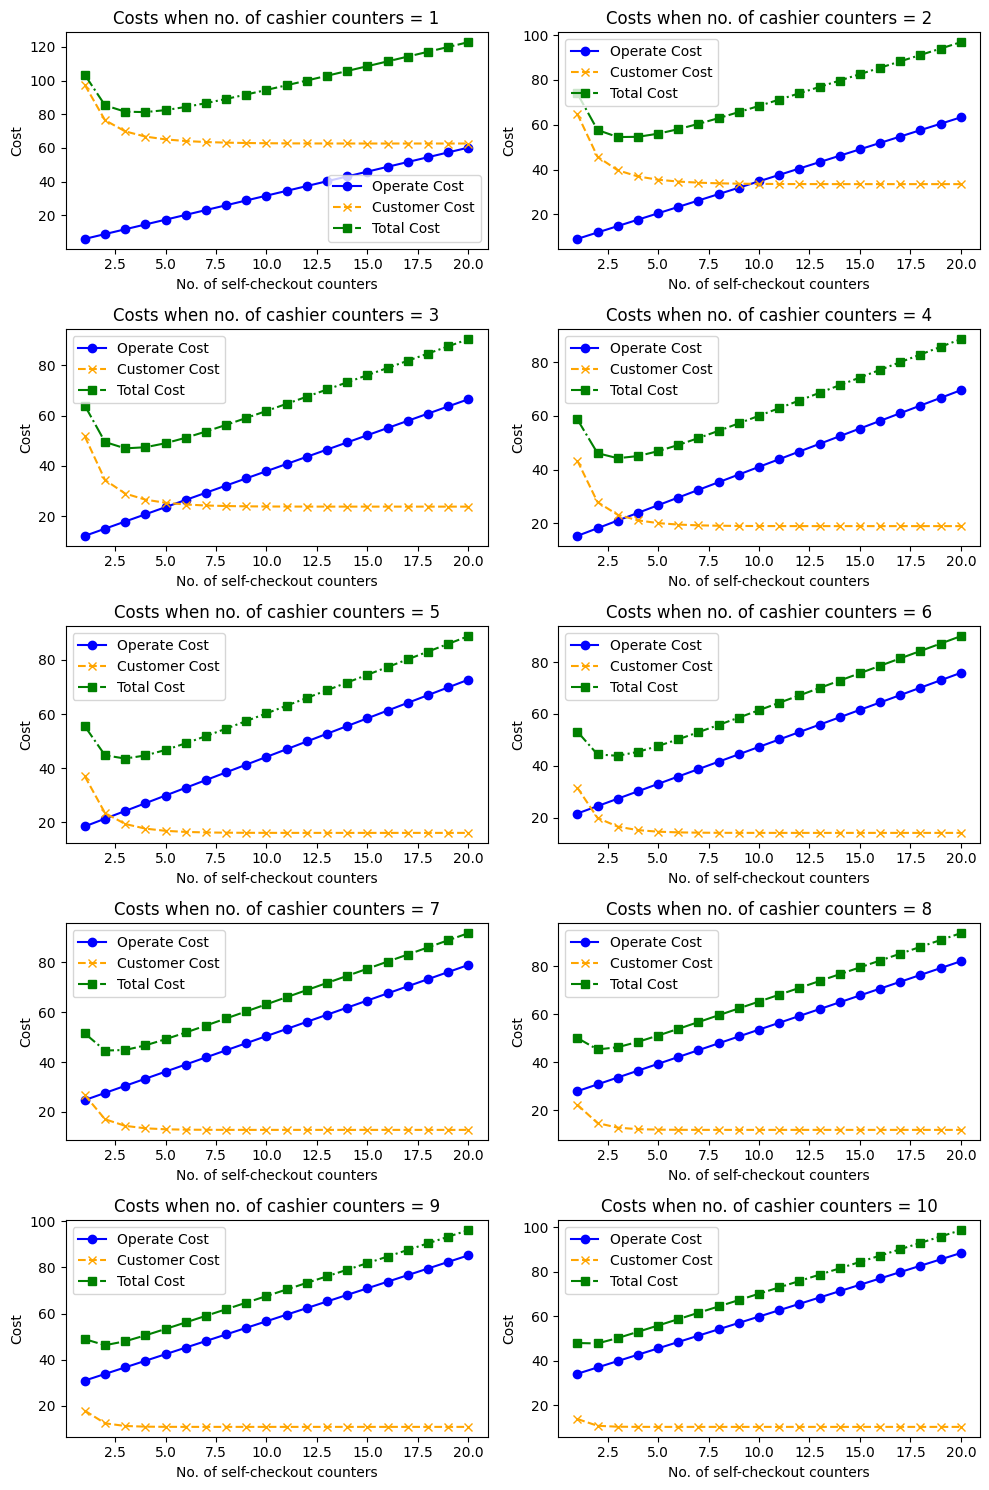

In [85]:
groups = df_simulation.groupby("c1")

# Create a multiplot grid
fig, axes = plt.subplots(5, 2, figsize=(10, 15))  # 5 rows, 2 columns for 10 subplots
axes = axes.flatten()  # Flatten the axes for easy iteration

# Iterate over each c1 group and plot the data
for i, (c1, group) in enumerate(groups):
    ax = axes[i]  # Select the corresponding subplot

    # Plot the three costs against c2
    ax.plot(group["c2"], group["operate_cost"], label="Operate Cost", linestyle='-', marker='o', color='blue')
    ax.plot(group["c2"], group["customer_cost"], label="Customer Cost", linestyle='--', marker='x', color='orange')
    ax.plot(group["c2"], group["total_cost"], label="Total Cost", linestyle='-.', marker='s', color='green')

    # Add title and labels
    ax.set_title(f"Costs when no. of cashier counters = {c1}")
    ax.set_xlabel("No. of self-checkout counters")
    ax.set_ylabel("Cost")
    ax.legend()

# Adjust layout for readability
plt.tight_layout()

# Show the plot
plt.show()

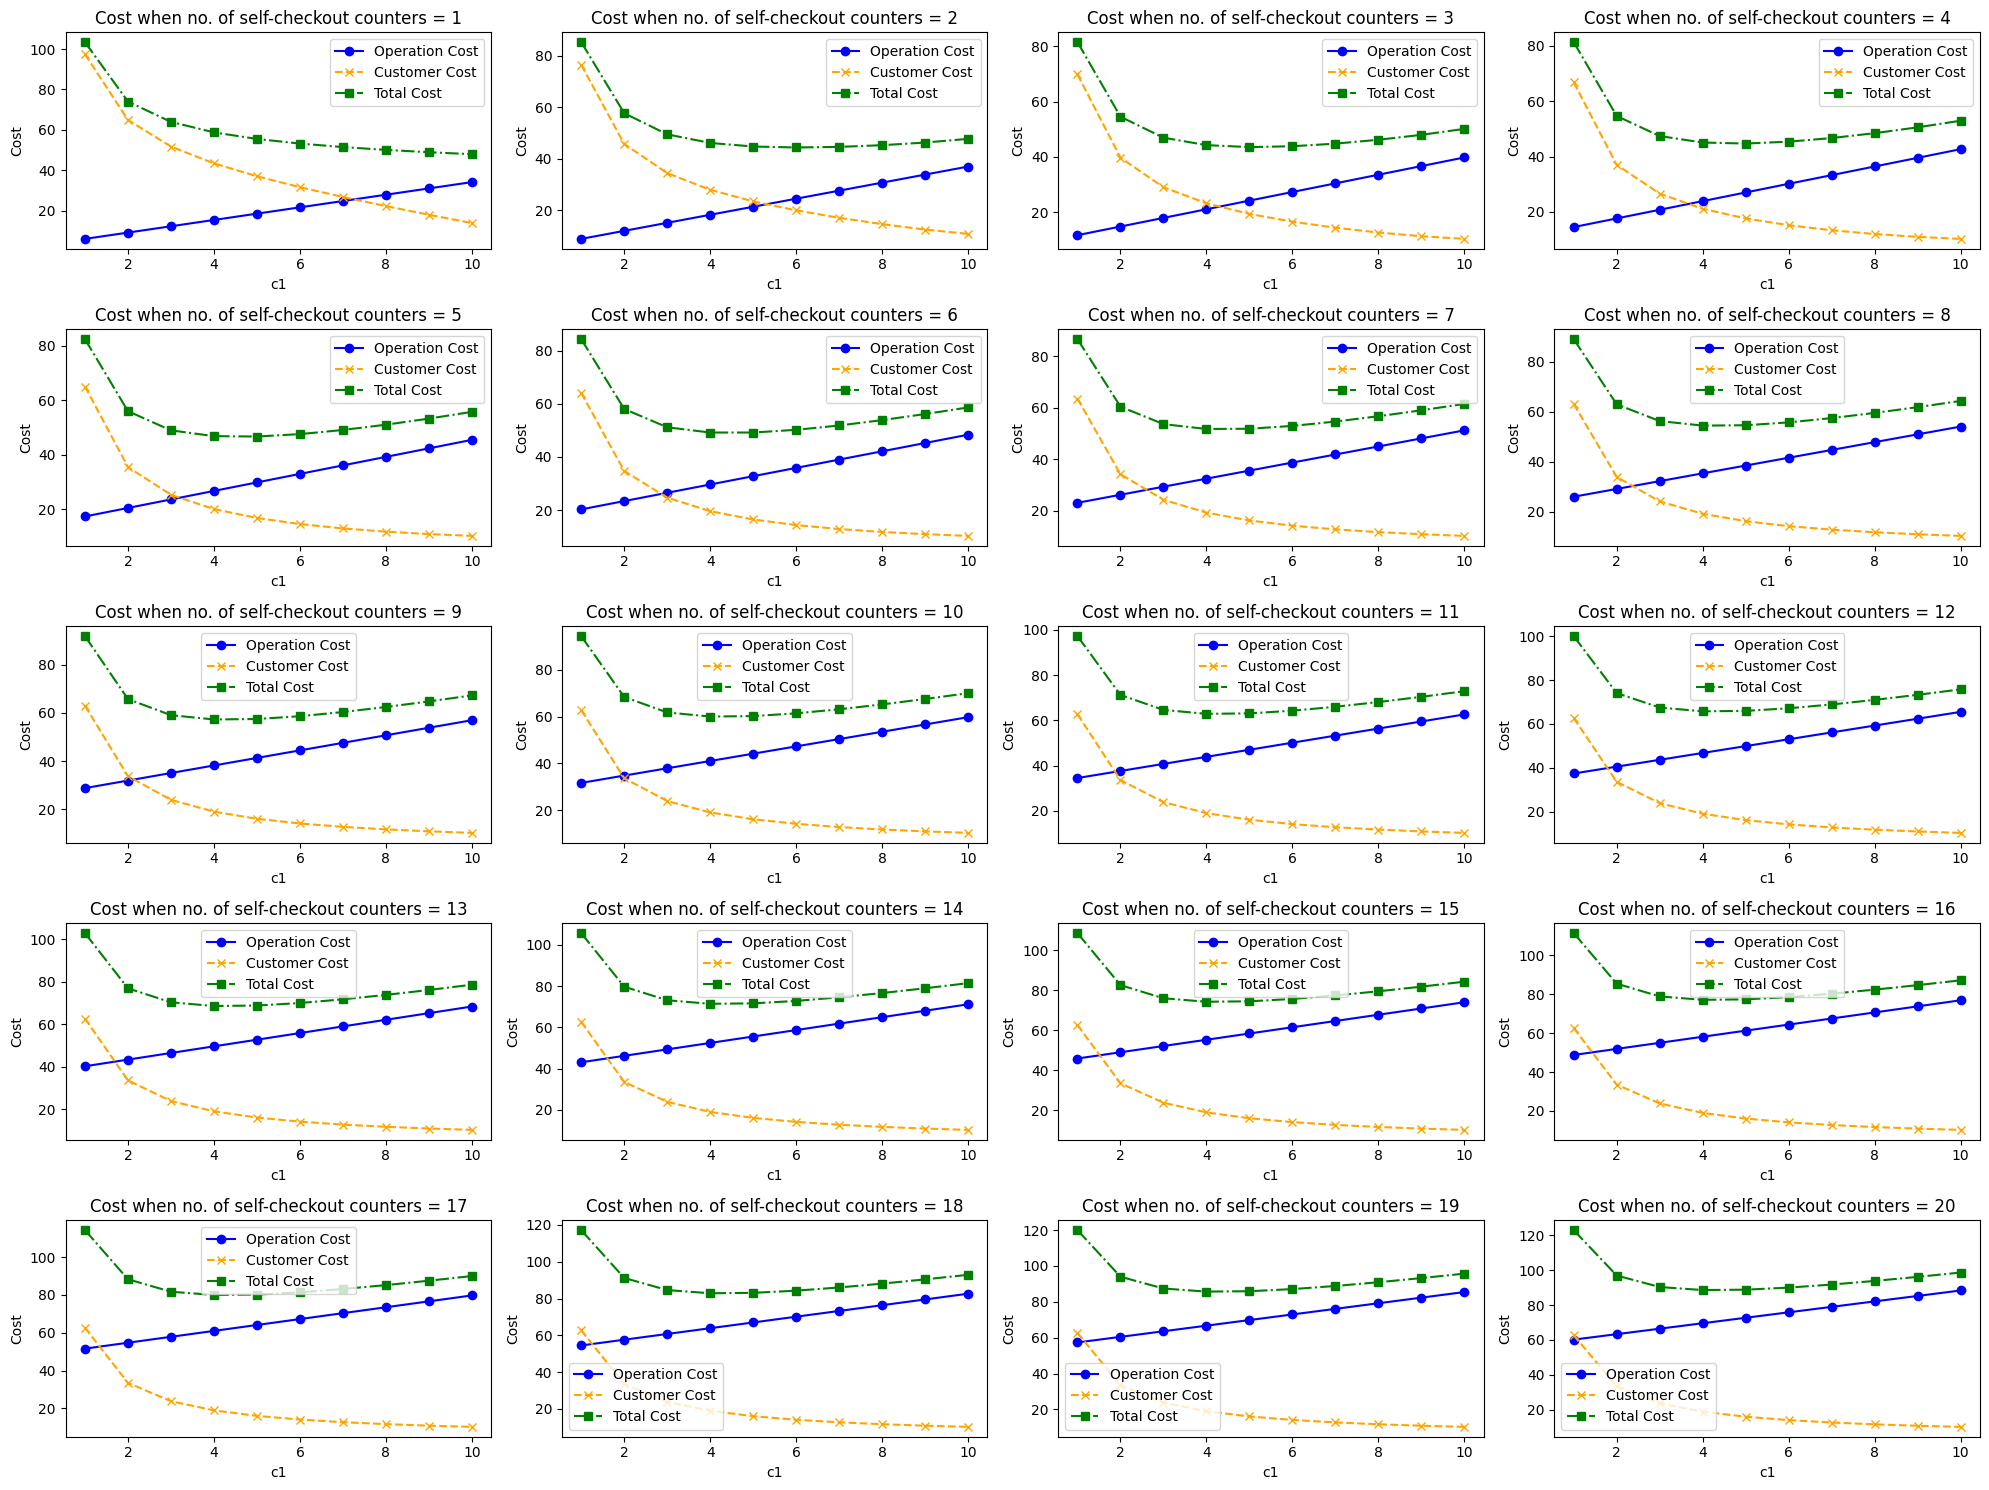

In [86]:
groups = df_simulation.groupby("c2")

# Create a multiplot grid
fig, axes = plt.subplots(5, 4, figsize=(20, 15))  # 5 rows, 2 columns for 10 subplots
axes = axes.flatten()  # Flatten the axes for easy iteration

min_rows = []
# Iterate over each c1 group and plot the dataz
for i, (c2, group) in enumerate(groups):
    ax = axes[i]  # Select the corresponding subplot

    # Plot the three costs against c1
    ax.plot(group["c1"], group["operate_cost"], label="Operation Cost", linestyle='-', marker='o', color='blue')
    ax.plot(group["c1"], group["customer_cost"], label="Customer Cost", linestyle='--', marker='x', color='orange')
    ax.plot(group["c1"], group["total_cost"], label="Total Cost", linestyle='-.', marker='s', color='green')
    min_row = group.loc[group["total_cost"].idxmin()]
    min_rows.append(min_row)
    # Add title and labels
    ax.set_title(f"Cost when no. of self-checkout counters = {c2}")
    ax.set_xlabel("c1")
    ax.set_ylabel("Cost")
    ax.legend()


df_mins = pd.DataFrame(min_rows)
# Adjust layout for readability
plt.tight_layout()

# Show the plot
plt.show()

In [87]:
df_mins 

,c1,c2,lambda_mm1,lambda_mmc,mm1_perf,mmc_perf,operate_cost,customer_cost,total_cost
180,10.0,1.0,370.909091,37.926446,99.275424,136.415651,34.103881,13.814116,47.917997
101,6.0,2.0,222.545455,186.290083,165.459040,174.389603,24.457763,19.918907,44.376669
82,5.0,3.0,185.454545,223.380992,198.550848,131.908831,24.186644,19.368609,43.555253
83,5.0,4.0,185.454545,223.380992,198.550848,102.714464,27.040525,17.657495,44.698020
84,5.0,5.0,185.454545,223.380992,198.550848,88.826146,29.894406,16.843485,46.737891
65,4.0,6.0,148.363636,260.471901,248.188560,85.633365,29.623288,19.565674,49.188962
66,4.0,7.0,148.363636,260.471901,248.188560,80.735819,32.477169,19.278623,51.755792
67,4.0,8.0,148.363636,260.471901,248.188560,78.190179,35.331050,19.129421,54.460471
68,4.0,9.0,148.363636,260.471901,248.188560,76.913228,38.184932,19.054577,57.239508
69,4.0,10.0,148.363636,260.471901,248.188560,76.302266,41.038813,19.018768,60.057581


In [88]:
df_mins.loc[df_mins["total_cost"].idxmin()]

c1                 5.000000
c2                 3.000000
lambda_mm1       185.454545
lambda_mmc       223.380992
mm1_perf         198.550848
mmc_perf         131.908831
operate_cost      24.186644
customer_cost     19.368609
total_cost        43.555253
Name: 82, dtype: float64

In [89]:
df_simulation.loc[(df_simulation["c1"] == 1) & (df_simulation["c2"] == 14)]

,c1,c2,lambda_mm1,lambda_mmc,mm1_perf,mmc_perf,operate_cost,customer_cost,total_cost
13,1,14,37.090909,371.744628,992.754238,76.014428,43.079338,62.641719,105.721057
